In [6]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import re
import random
import json
from multiprocessing.dummy import Pool as ThreadPool
import dask.dataframe as dd
import random
from datetime import datetime
import time

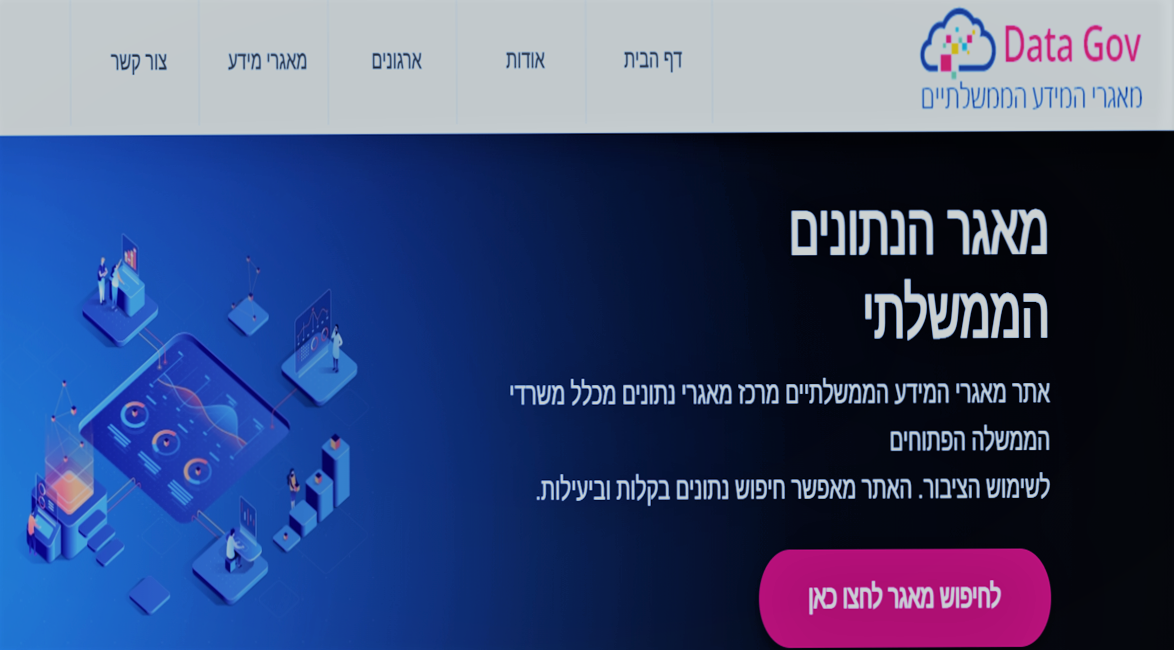

In [14]:
from IPython import display
display.Image(r'C:\Users\avrahams\Desktop\DataGovProject\אפיון בדיקות\logo_datagov.png')


# Data.gov.il -  website that provides free access to databases of all government ministries. The site enables data search easily and efficiently


# link to data.gov
## https://info.data.gov.il/datagov/home/

# Research Process:
## 1. Collect and build dataframe of all databases stored in data.gov.
## 2. Select population (xls,xlsx,csv) that has an valid response_code.
## 3. Run generic data quality function over population.
## 4. Consolidate results to data frame.

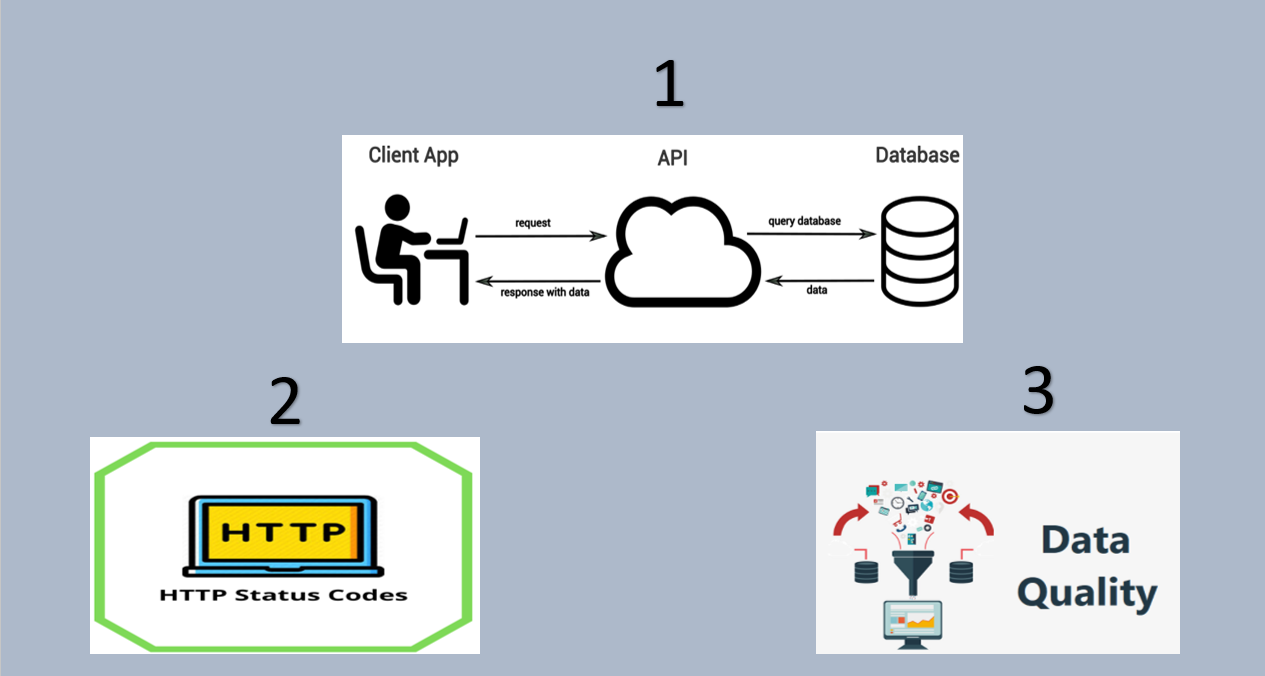

In [13]:
from IPython import display
display.Image(r'C:\Users\avrahams\Desktop\DataGovProject\אפיון בדיקות\ETL_Process.png')

## importing data.gov.il databases structure that spread out on ckan. 
### CKAN - open-source DMS .CKAN makes it easy to publish, share and use data

In [10]:
%%time
r = requests.get('https://data.gov.il/api/action/package_search?rows=1000&start=0')

Wall time: 1.63 s


In [11]:
r.json().keys()

dict_keys(['help', 'success', 'result'])

### sample of data gov APi output in JSON format

In [18]:
r.json()['result']['results'][0]['resources']

[{'cache_last_updated': None,
  'cache_url': None,
  'ckan_url': 'https://e.data.gov.il',
  'created': '2021-05-13T08:08:22.324213',
  'datastore_active': True,
  'datastore_contains_all_records_of_source_file': True,
  'description': None,
  'format': 'CSV',
  'hash': '',
  'id': '6f6acd03-f351-4a8f-8ecf-df792f4f573a',
  'ignore_hash': False,
  'last_modified': '2022-02-22T10:48:29.502473',
  'metadata_modified': '2022-02-22T10:48:29.575265',
  'mimetype': 'text/csv',
  'mimetype_inner': None,
  'name': 'מספרי רישוי של כלי רכב לא פעילים וחסרי קוד דגם',
  'notes': '',
  'original_url': 'https://e.data.gov.il/dataset/8672aa2c-3873-443a-b1ea-47ad546c6043/resource/6f6acd03-f351-4a8f-8ecf-df792f4f573a/download/6f6acd03-f351-4a8f-8ecf-df792f4f573a.csv',
  'package_id': '8672aa2c-3873-443a-b1ea-47ad546c6043',
  'position': 0,
  'resource_coordinates': '',
  'resource_desc_spatial_cover': '',
  'resource_geodetic_ref_sys': '',
  'resource_id': '6f6acd03-f351-4a8f-8ecf-df792f4f573a',
  'resour

# Retrieve dataset from data.gov.il with API request
### url = data file address
### r = requests.get(url)
### df_test = pd.DataFrame(r.json()['result']['records'])
### Note : complete url should be url+ specific data file id from r_id column and num of records (limit)
### example : https://data.gov.il/api/3/action/datastore_search?resource_id=56063a99-8a3e-4ff4-912e-5966c0279bad&limit=5

### convert json to data frames that contains all necessary data  

In [15]:
df_data =pd.DataFrame(list(r.json()['result']['results']),dtype = object)
df_orgs = df_data[['id','organization']].drop_duplicates('id')
df_resource = df_data[['id','resources','title']]

### sample of data frame that contains json's of data  files

In [19]:
df_resource.head()

,id,resources,title
0,8672aa2c-3873-443a-b1ea-47ad546c6043,"[{'cache_last_updated': None, 'cache_url': Non...",מספרי רישוי של כלי רכב לא פעילים וחסרי קוד דגם
1,45e317cf-7bb1-4535-b8cf-be5e79ea341f,"[{'cache_last_updated': None, 'cache_url': Non...",תוצרים ודגמים של כלי רכב פרטי ומסחרי
2,273c5e33-25ab-4980-8522-a2f7ba0bb62d,"[{'cache_last_updated': None, 'cache_url': Non...",היסטוריית כלי רכב פרטיים
3,392abd0a-64f6-4c18-9d56-0111001411e6,"[{'cache_last_updated': None, 'cache_url': Non...",סוחרי רכב
4,90723376-9db7-4bde-90c0-6f3d5b5cdf9d,"[{'cache_last_updated': None, 'cache_url': Non...",מערכת בטיחות ברכב


### create dataframe that display government ministrie title and relevent datafiles id's

In [16]:
list_id = [x for x in df_orgs['id']]
list_org = [y.get('title','None') for y in df_orgs['organization']]
df_org_name_id = pd.DataFrame(list(zip(list_id,list_org)),columns = ['id','org_name'])
df_org_name_id.head()

,id,org_name
0,8672aa2c-3873-443a-b1ea-47ad546c6043,משרד התחבורה והבטיחות בדרכים
1,45e317cf-7bb1-4535-b8cf-be5e79ea341f,משרד התחבורה והבטיחות בדרכים
2,273c5e33-25ab-4980-8522-a2f7ba0bb62d,משרד התחבורה והבטיחות בדרכים
3,392abd0a-64f6-4c18-9d56-0111001411e6,משרד התחבורה והבטיחות בדרכים
4,90723376-9db7-4bde-90c0-6f3d5b5cdf9d,משרד התחבורה והבטיחות בדרכים


# Part 1 - Data Preparation

## Creating metadata includes: Organization title , DataFrame title and other essential features

In [20]:
package_list=[]
for x in df_resource['resources']:
    for y in x:
        package_list.append([y.get('package_id','None')]+[y.get('name','None')]+[y.get('resource_id')]+[y.get('format')]+[y.get('datastore_contains_all_records_of_source_file',0)]+[y.get('id',0)])
df_resource_meta_data = pd.DataFrame(package_list,columns=['package_id','file_name','resource_id','format','datastore_contains_all_records_of_source_file','r_id']).reset_index(drop = True)

In [21]:
df_resource_meta_data.head()

,package_id,file_name,resource_id,format,datastore_contains_all_records_of_source_file,r_id
0,8672aa2c-3873-443a-b1ea-47ad546c6043,מספרי רישוי של כלי רכב לא פעילים וחסרי קוד דגם,6f6acd03-f351-4a8f-8ecf-df792f4f573a,CSV,True,6f6acd03-f351-4a8f-8ecf-df792f4f573a
1,45e317cf-7bb1-4535-b8cf-be5e79ea341f,תוצרים ודגמים של כלי רכב WLTP,142afde2-6228-49f9-8a29-9b6c3a0cbe40,CSV,True,142afde2-6228-49f9-8a29-9b6c3a0cbe40
2,45e317cf-7bb1-4535-b8cf-be5e79ea341f,"מאגר כמויות כלי רכב לפי תוצר, דגם ושנת יצור",5e87a7a1-2f6f-41c1-8aec-7216d52a6cf6,CSV,True,5e87a7a1-2f6f-41c1-8aec-7216d52a6cf6
3,45e317cf-7bb1-4535-b8cf-be5e79ea341f,מבנה הנתונים במאגר,None,PDF,False,68b875de-5716-4156-b4dd-2a4fc70b669b
4,273c5e33-25ab-4980-8522-a2f7ba0bb62d,היסטוריית כלי רכב פרטיים (1),56063a99-8a3e-4ff4-912e-5966c0279bad,CSV,True,56063a99-8a3e-4ff4-912e-5966c0279bad


## Distinct count of Databases
### Database can include multiple data files in several formats such as :CSV,XLSX,XML,KMZ et cetera 

In [23]:
df_resource_meta_data.package_id.nunique()

933

## population : data files in formats such as :CSV,XLSX,XLS

In [24]:
df_test = df_resource_meta_data[df_resource_meta_data['format'].isin(['CSV','XLSX','XLS'])]

## population size

In [25]:
df_test.r_id.nunique()

1457

In [26]:
df_test = df_test.merge(df_resource[['id','title']],how = 'inner',left_on = 'package_id',right_on = 'id')
df_test = df_test.merge(df_org_name_id,how = 'inner',left_on = 'package_id',right_on = 'id')

## Adding organizations titles to population dataset

In [27]:
df_test = df_test[['package_id','title','file_name','format','org_name','r_id']]
df_test.head()

,package_id,title,file_name,format,org_name,r_id
0,8672aa2c-3873-443a-b1ea-47ad546c6043,מספרי רישוי של כלי רכב לא פעילים וחסרי קוד דגם,מספרי רישוי של כלי רכב לא פעילים וחסרי קוד דגם,CSV,משרד התחבורה והבטיחות בדרכים,6f6acd03-f351-4a8f-8ecf-df792f4f573a
1,45e317cf-7bb1-4535-b8cf-be5e79ea341f,תוצרים ודגמים של כלי רכב פרטי ומסחרי,תוצרים ודגמים של כלי רכב WLTP,CSV,משרד התחבורה והבטיחות בדרכים,142afde2-6228-49f9-8a29-9b6c3a0cbe40
2,45e317cf-7bb1-4535-b8cf-be5e79ea341f,תוצרים ודגמים של כלי רכב פרטי ומסחרי,"מאגר כמויות כלי רכב לפי תוצר, דגם ושנת יצור",CSV,משרד התחבורה והבטיחות בדרכים,5e87a7a1-2f6f-41c1-8aec-7216d52a6cf6
3,273c5e33-25ab-4980-8522-a2f7ba0bb62d,היסטוריית כלי רכב פרטיים,היסטוריית כלי רכב פרטיים (1),CSV,משרד התחבורה והבטיחות בדרכים,56063a99-8a3e-4ff4-912e-5966c0279bad
4,273c5e33-25ab-4980-8522-a2f7ba0bb62d,היסטוריית כלי רכב פרטיים,היסטוריית כלי רכב פרטיים (2),CSV,משרד התחבורה והבטיחות בדרכים,fc6f5096-86dc-4a34-b3e3-2fca9696b2d6


## create a list of population id's for future research

In [11]:
res_list = [x for x in df_test['r_id']]
res_list = list(dict.fromkeys(res_list))
random.shuffle(res_list)

### Check data file availability using server response code : 200 - valid , 404 - not found
### The function also calculates datafram size: num of rows and columns that stored in file system.
### Significance of getting response code 200 is that stored data can be retrieved with APi request. 

In [3]:
global format
format = "%Y-%m-%d %H:%M:%S"
def check_response(resource_id):
    time.sleep(2)
    print(datetime.now())
    url = 'https://data.gov.il/api/3/action/datastore_search?resource_id='+resource_id+'&limit=2&include_total=true'
    shape = 0
    rows = 0
    try:
        r = requests.get(url)
        if (r.status_code == 200):
            df_test = pd.DataFrame(r.json()['result']['records'])
            shape = r.json()['result'].get('total') * (df_test.shape[1])
            rows = r.json()['result'].get('total') 
    except:
        pass
    if rows>0:
        return [resource_id , requests.get(url).status_code,datetime.now().strftime(format),rows,int((shape/rows)-1)]
    else:
        return [resource_id , requests.get(url).status_code,datetime.now().strftime(format),rows,"Empty_df"]  

## Example of output from "check_response" function

In [97]:
check_response('e83f763b-b7d7-479e-b172-ae981ddc6de5')

2021-10-19 19:05:05.215094


['e83f763b-b7d7-479e-b172-ae981ddc6de5', 200, '2021-10-19 19:05:06', 1407, 17]

## Run function all over population to map out  data.gov.il response_codes
### in order to accelerate run time (iterate function over approximately 1500 data files) and to  achieve concurrency of execution in a computer program Thread pool exceuted

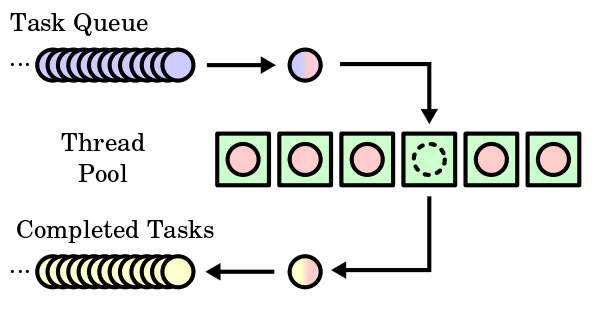

In [12]:
display.Image(r'C:\Users\avrahams\Desktop\DataGovProject\אפיון בדיקות\Thread_pool.png')

In [ ]:
now = datetime.now()
if __name__ == "__main__":
    pool = ThreadPool(4)  # Make the Pool of workers
    response_results = pool.map(check_response, res_list) #Open the urls in their own threads
    pool.close() #close the pool and wait for the work to finish 
    pool.join()

##  Aggregating final results (response codes, size) to dataframe

In [14]:
df = pd.DataFrame(response_results,columns =['resource_id','response_code','Create_Time','rows_count','columns_count'])
df.response_code.value_counts(normalize = True)

200    0.83125
404    0.16875
Name: response_code, dtype: float64

# part 2 - Data quality test

### retrieve data using API request function

In [29]:
def get_DB_data(resource_id):
    url ='https://data.gov.il/api/3/action/datastore_search?resource_id='+resource_id+'&limit=100000'
    try:
            r = requests.get(url)
            df_test = pd.DataFrame(r.json()['result']['records'])
            return df_test
    except:
        return pd.DataFrame()

In [30]:
df_1 = get_DB_data('56063a99-8a3e-4ff4-912e-5966c0279bad')
df_1.head()

,_id,mispar_rechev,mispar_manoa,kilometer_test_aharon,shinui_mivne_ind,gapam_ind,shnui_zeva_ind,shinui_zmig_ind,rishum_rishon_dt
0,1,3883580,CZD 488579,73318.0,1,0,0,1,2017-04-19T00:00:00
1,2,3964230,63809750,113986.0,1,0,0,1,2017-03-27T00:00:00
2,3,91871101,65193032850775,426845.0,1,0,1,1,2020-07-20T00:00:00
3,4,6454286,V525679,138188.0,1,0,0,1,2017-04-28T00:00:00
4,5,8906439,17798060013292,109933.0,1,0,1,1,2017-01-01T00:00:00


## 1. Find_Url function - > checks if there is website address within string
## 2. check_response_test -> checks webpage availability (response code status)
## 3. eror_logs_test -> main quality function that include content test:
####  3.1 Detect NULL,space/spaces 
####  3.2 Detect special characters 
####  3.3 checks if website address exist
####  3.4 check if value contains html tags
### Output of data quality function is aggregative log file results for database id.

In [5]:
def Find_Url(string): 
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)     
    url =list(dict.fromkeys([x[0] for x in url]))
    return url
###########################################################
def check_response_test(url):
    try:    
        r = requests.get(url)
        if(r.status_code == 200):
            pass
    except:
        return 'Invalid_Link'
##########################################################
def eror_logs_test(resource_id):
    print(resource_id,datetime.now())
    df = get_DB_data(resource_id)
    col_name,index_list,eror_type,result_list,temp_list = ([] for i in range(5))
    if ((~df.empty)):
        col_names = df.columns
        num_of_iterations = list(range(len(col_names)))
        for i in tqdm(num_of_iterations,desc = 'progress'):
            for index,row in tqdm(df.iterrows(),desc = 'progress'):
                mask_space = len(' '.join(str(row[i]).split()))== 0
                special_char = re.sub('[!@#$%^&*(),.?":{}|<>]','',str(row[i]))
                tag_eror = ('>' in str(row[i]) or '<' in str(row[i]))
                now = str(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                if (pd.isnull(row[i])!=True):
                    if ((mask_space) or (str(row[i]).lower()=='null') or (pd.isnull(row[i]))):
                        result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['space']+[row[i]]+[str(now)])
                    elif(len(special_char)==0):
                        result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['special_char']+[row[i]]+[str(now)])
                    elif (len(Find_Url(str(row[i])))>0):    
                        try:
                            html = Find_Url(row[i])[0]
                            parsed_uri = urlparse(html)
                            if ('{uri.scheme}://{uri.netloc}'.format(uri=parsed_uri) not in temp_list):
                                temp_list.append('{uri.scheme}://{uri.netloc}'.format(uri=parsed_uri))
                                if (check_response_test(html) == 'Invalid_Link') :
                                    result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['Invalid_Link']+[html]+[str(now)])
                                else:
                                    pass
                            else:
                                pass
                        except:
                            pass
                    elif(tag_eror):
                            result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['tag_eror']+[row[i]]+[str(now)])       
                    elif(str(row[i]).lower()=='null'):
                            result_list.append([random.randint(0,1000)]+[col_names[i]]+[index]+['null']+[row[i]]+[str(now)])
                else:
                    pass
                
        df_log = pd.DataFrame(result_list,columns = (['Test_Id','Col_name','index','Eror_Type','Value','Time']))
        df_log['resource_id'] = resource_id
        if(df_log.shape[0]>0):
            return df_log.groupby(['resource_id','Eror_Type'])['Test_Id'].agg('count').reset_index()
        else:
            pass

## example of using data quality function ("eror_logs_test") 

In [34]:
%time df1 = eror_logs_test('a976089d-e8e5-4013-8f3d-777b8551c684')
df1

a976089d-e8e5-4013-8f3d-777b8551c684 2022-02-23 10:03:11.361018


progress:   0%|                                                                                 | 0/18 [00:00<?, ?it/s]
progress: 17it [00:00, 4260.72it/s]

progress: 17it [00:00, 8526.03it/s]

progress: 17it [00:00, 4262.76it/s]

progress: 17it [00:00, 8514.83it/s]

progress: 17it [00:00, 4257.67it/s]

progress: 17it [00:00, 5677.00it/s]

progress: 17it [00:00, 4178.33it/s]

progress: 17it [00:00, 2212.80it/s]
progress:  44%|████████████████████████████████▍                                        | 8/18 [00:00<00:00, 78.20it/s]
progress: 17it [00:00, 3408.21it/s]

progress: 17it [00:00, 4260.72it/s]

progress: 17it [00:00, 5308.06it/s]

progress: 17it [00:00, 4847.26it/s]

progress: 17it [00:00, 3408.70it/s]

progress: 17it [00:00, 5677.91it/s]

progress: 17it [00:00, 8526.03it/s]

progress: 17it [00:00, 5681.07it/s]

progress: 17it [00:00, 5679.26it/s]

progress: 17it [00:00, 10733.58it/s]
progress: 100%|████████████████████████████████████████████████████████████████████████| 18/18 

Wall time: 747 ms


,resource_id,Eror_Type,Test_Id
0,a976089d-e8e5-4013-8f3d-777b8551c684,space,165


## Select non-empty dataframes that has response code 200 

In [17]:
test_list = df[(df.rows_count!=0)&(df.response_code==200)].resource_id.to_list()
random.shuffle(test_list)

## population size

In [131]:
len(test_list)

1294

## Apply data quality function ("eror_logs_test") on population with threadpool 

In [ ]:
now = datetime.now()
if __name__ == "__main__":
    pool = ThreadPool(4)  # Make the Pool of workers
    results = pool.map(eror_logs_test, test_list) #Open the urls in their own threads
    pool.close() #close the pool and wait for the work to finish 
    pool.join()

## Aggregate the results to df

In [29]:
df_total_results = pd.DataFrame()
for x in results:
    df_total_results = pd.concat([df_total_results,x],axis = 0)

df_total_results

,resource_id,Eror_Type,Test_Id
0,ae397d08-effe-4769-aacd-b8454f063ce2,space,240
0,e7830e8d-9a0b-4e42-ab5f-f5e2e0ddc568,space,121
0,1505933d-f495-4fc7-8f8d-39dddd2e8070,space,7
1,1505933d-f495-4fc7-8f8d-39dddd2e8070,special_char,2
0,b55cd343-c64b-4741-a8c4-6ab81e8eb68e,space,788
...,...,...,...
0,ef1c8e7f-9287-4b29-889d-26dbb9c9ad46,space,240
0,6b1c032a-fdc1-4f92-bee1-14d6bf6af910,space,3
0,a2dd714b-e012-46e4-a996-6307f8b46fc5,space,20672
0,2c33523f-87aa-44ec-a736-edbb0a82975e,space,60


## Adding features:
#### Total_values_Tested -  in case  the limit of records that asked from API request was lower from the actual num of records
#### the total records consider 100K otherwise the total records equal to the actual records tha stored in server.
#### Total_Values - num of records that stored in file system.
#### eror percentage - calculate error percentage per error type

In [30]:
df_final = df[(df.response_code==200)&(df.rows_count>0)].merge(df_total_results,how = 'inner',on = 'resource_id')
df_final['Total_values_Tested'] = np.where(df_final['rows_count'] >=100000,100000*df_final['columns_count'],df_final['columns_count']*df_final['rows_count'])
df_final['%sample'] = np.where((100000/df_final['rows_count'])<1,100000/df_final['rows_count'],1)
df_final['%errors'] = df_final['Test_Id']/df_final['Total_values_Tested']
df_final['Total_Values'] = df_final['rows_count']*df_final['columns_count']
df_final.head()

,resource_id,response_code,Create_Time,rows_count,columns_count,Eror_Type,Test_Id,Total_values_Tested,%sample,%errors,Total_Values
0,388992c7-0280-48d8-b147-13e636bd804d,200,2021-10-25 19:42:00,39,6,space,75,234,1.000000,0.320513,234
1,29f4ec99-ec7f-43c1-947e-60a960980607,200,2021-10-25 19:42:12,609,26,space,3925,15834,1.000000,0.247884,15834
2,29f4ec99-ec7f-43c1-947e-60a960980607,200,2021-10-25 19:42:12,609,26,tag_eror,1418,15834,1.000000,0.089554,15834
3,d65cfb3a-3db2-46f5-a6cb-fddac454e6d9,200,2021-10-25 19:42:18,12,15,space,6,180,1.000000,0.033333,180
4,cee3ad4a-4e77-4015-8245-52505417d7ea,200,2021-10-25 19:42:25,1465599,20,space,525803,2000000,0.068231,0.262902,29311980


In [31]:
df_final =df_final.merge(df_test[['title','file_name','org_name','r_id']],how = 'inner',left_on = 'resource_id',right_on = 'r_id')
df_final.head()

,resource_id,response_code,Create_Time,rows_count,columns_count,Eror_Type,Test_Id,Total_values_Tested,%sample,%errors,Total_Values,title,file_name,org_name,r_id
0,388992c7-0280-48d8-b147-13e636bd804d,200,2021-10-25 19:42:00,39,6,space,75,234,1.000000,0.320513,234,ביטוח-נט,פירוט שינויים פורמט חדש ביטוח.xlsx,רשות שוק ההון,388992c7-0280-48d8-b147-13e636bd804d
1,29f4ec99-ec7f-43c1-947e-60a960980607,200,2021-10-25 19:42:12,609,26,space,3925,15834,1.000000,0.247884,15834,אטרקציות - Attractions,Attraction_GOISRAEL_Hebrew,משרד התיירות,29f4ec99-ec7f-43c1-947e-60a960980607
2,29f4ec99-ec7f-43c1-947e-60a960980607,200,2021-10-25 19:42:12,609,26,tag_eror,1418,15834,1.000000,0.089554,15834,אטרקציות - Attractions,Attraction_GOISRAEL_Hebrew,משרד התיירות,29f4ec99-ec7f-43c1-947e-60a960980607
3,d65cfb3a-3db2-46f5-a6cb-fddac454e6d9,200,2021-10-25 19:42:18,12,15,space,6,180,1.000000,0.033333,180,"תמ""א 42","תמ""א 42 - מנשקים CSV",משרד התחבורה והבטיחות בדרכים,d65cfb3a-3db2-46f5-a6cb-fddac454e6d9
4,cee3ad4a-4e77-4015-8245-52505417d7ea,200,2021-10-25 19:42:25,1465599,20,space,525803,2000000,0.068231,0.262902,29311980,ארכיון נתונים מטאורולוגיים,נתונים יומיים,השירות המטאורולוגי,cee3ad4a-4e77-4015-8245-52505417d7ea


# Possible Analysis KPi's:
## Total errors and the type of errors in general.
## Percentage of errors according to the values tested.
## Percentage of values accessible per organization.
# Adding google analytics data for future research .